/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_48433/2443113496.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='champion', data=top_10_win_rate, palette='viridis')
/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_48433/2443113496.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='side', y='result', data=side_stats, palette='coolwarm')
/var/folders/lw/8cn9x_rs75j7xkv0456m5s1w0000gn/T/ipykernel_48433/2443113496.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='win_rate', y='objective', dat

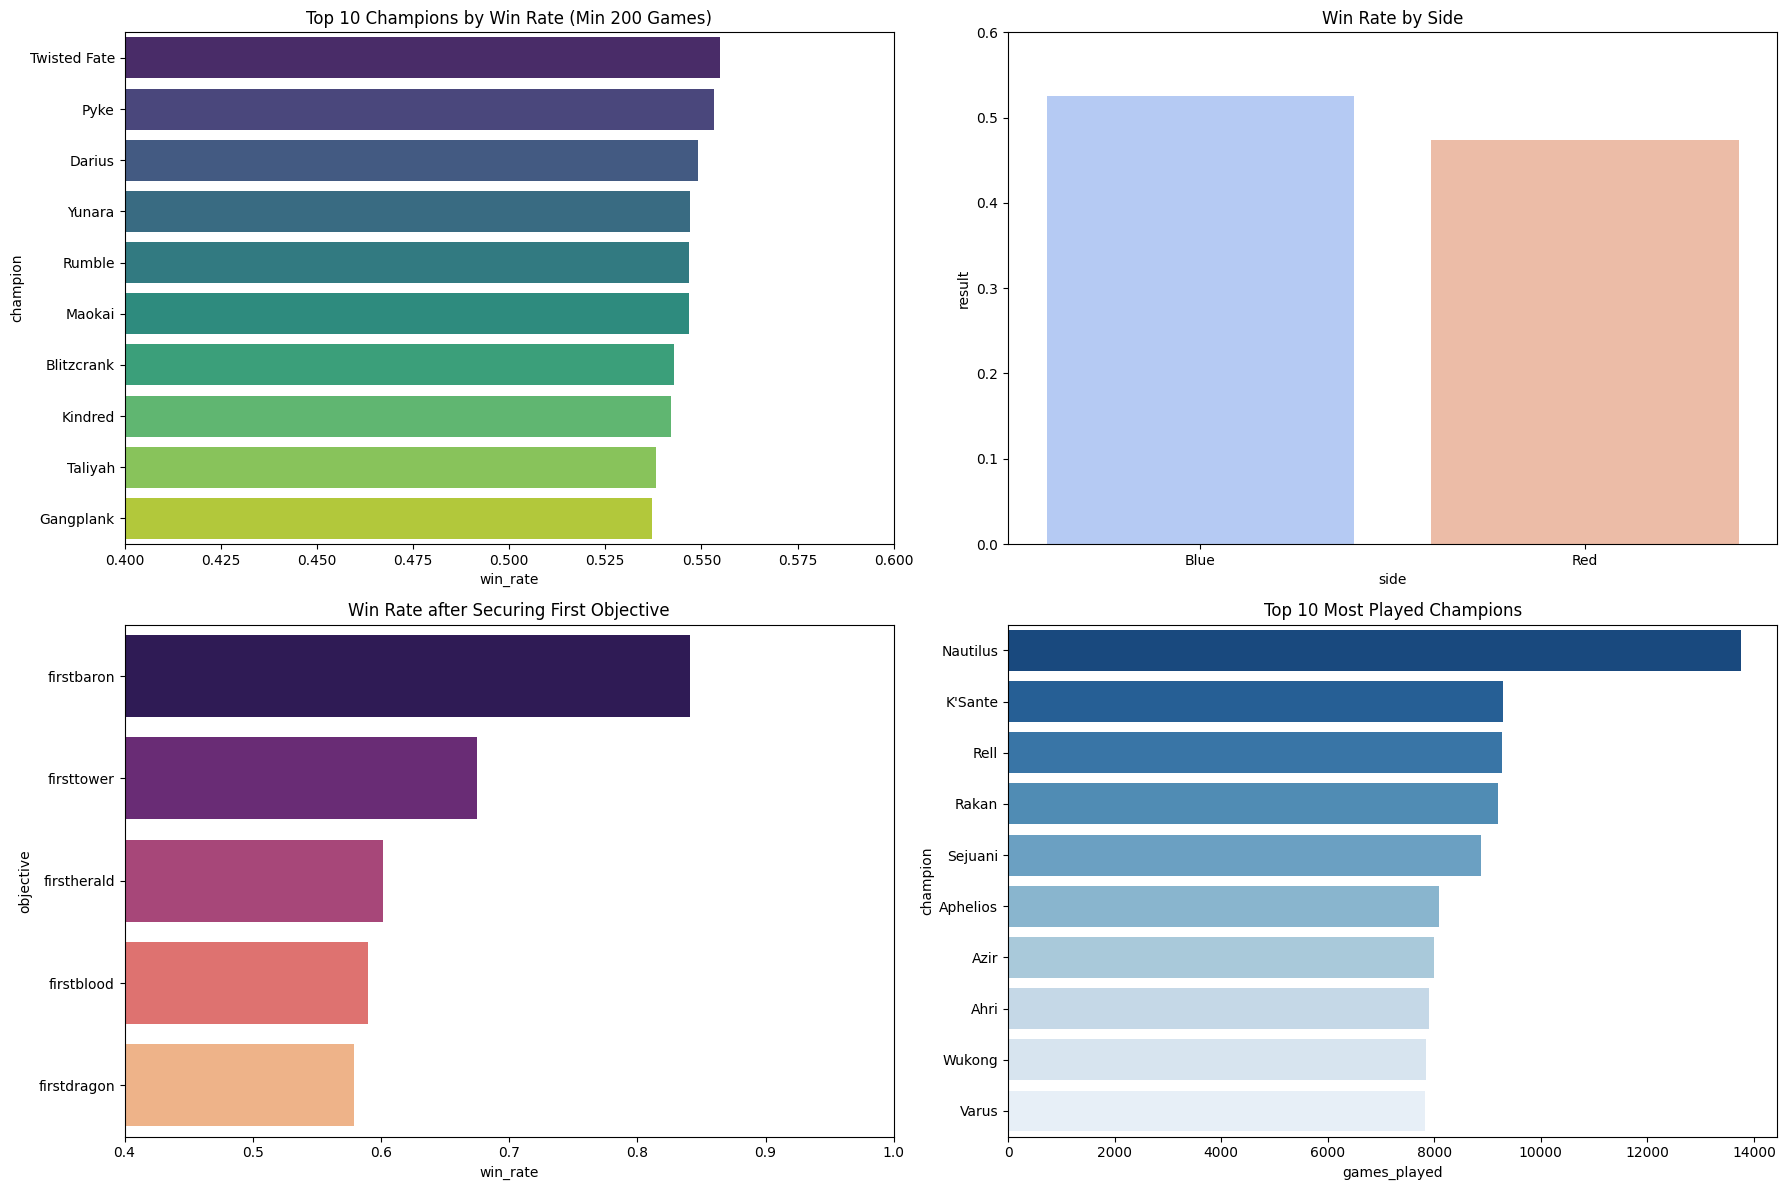

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data
game_result_df = pd.read_csv('../../data_clean/game_result.csv')
realtime_df = pd.read_csv('../../data_clean/realtime.csv')

# --- 1. Champion Win Rates & Popularity ---
# Combine Blue and Red team data into a single 'long' format
blue_cols = ['bot_blue', 'jng_blue', 'mid_blue', 'sup_blue', 'top_blue']
red_cols = ['bot_red', 'jng_red', 'mid_red', 'sup_red', 'top_red']

# Blue team wins if win=1, Red team wins if win=0
blue_melted = game_result_df[blue_cols + ['win']].melt(id_vars='win', value_vars=blue_cols, value_name='champion')
blue_melted['result'] = blue_melted['win']

red_melted = game_result_df[red_cols + ['win']].melt(id_vars='win', value_vars=red_cols, value_name='champion')
red_melted['result'] = 1 - red_melted['win'] # Inverse result for red team

all_champs = pd.concat([blue_melted[['champion', 'result']], red_melted[['champion', 'result']]])

# Calculate stats
champ_stats = all_champs.groupby('champion')['result'].agg(['count', 'mean']).reset_index()
champ_stats.columns = ['champion', 'games_played', 'win_rate']

# Filter for champions with enough data (> 200 games) to avoid outliers
filtered_champs = champ_stats[champ_stats['games_played'] > 200]
top_10_win_rate = filtered_champs.sort_values('win_rate', ascending=False).head(10)
top_10_played = filtered_champs.sort_values('games_played', ascending=False).head(10)

# --- 2. Side Win Rate ---
side_stats = realtime_df.groupby('side')['result'].mean().reset_index()

# --- 3. Objective Impact ---
objectives = ['firstblood', 'firstdragon', 'firsttower', 'firstbaron', 'firstherald']
objective_win_rates = []

for obj in objectives:
    # Calculate win rate when the team secures the specific objective
    win_rate = realtime_df[realtime_df[obj] == 1.0]['result'].mean()
    objective_win_rates.append({'objective': obj, 'win_rate': win_rate})

obj_df = pd.DataFrame(objective_win_rates)

# --- Plotting ---
plt.figure(figsize=(18, 12))

# Subplot 1: Top Win Rate Champions
plt.subplot(2, 2, 1)
sns.barplot(x='win_rate', y='champion', data=top_10_win_rate, palette='viridis')
plt.title('Top 10 Champions by Win Rate (Min 200 Games)')
plt.xlim(0.4, 0.6)

# Subplot 2: Side Win Rate
plt.subplot(2, 2, 2)
sns.barplot(x='side', y='result', data=side_stats, palette='coolwarm')
plt.title('Win Rate by Side')
plt.ylim(0, 0.6)

# Subplot 3: Objective Impact
plt.subplot(2, 2, 3)
sns.barplot(x='win_rate', y='objective', data=obj_df.sort_values('win_rate', ascending=False), palette='magma')
plt.title('Win Rate after Securing First Objective')
plt.xlim(0.4, 1.0)

# Subplot 4: Most Played Champions
plt.subplot(2, 2, 4)
sns.barplot(x='games_played', y='champion', data=top_10_played, palette='Blues_r')
plt.title('Top 10 Most Played Champions')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

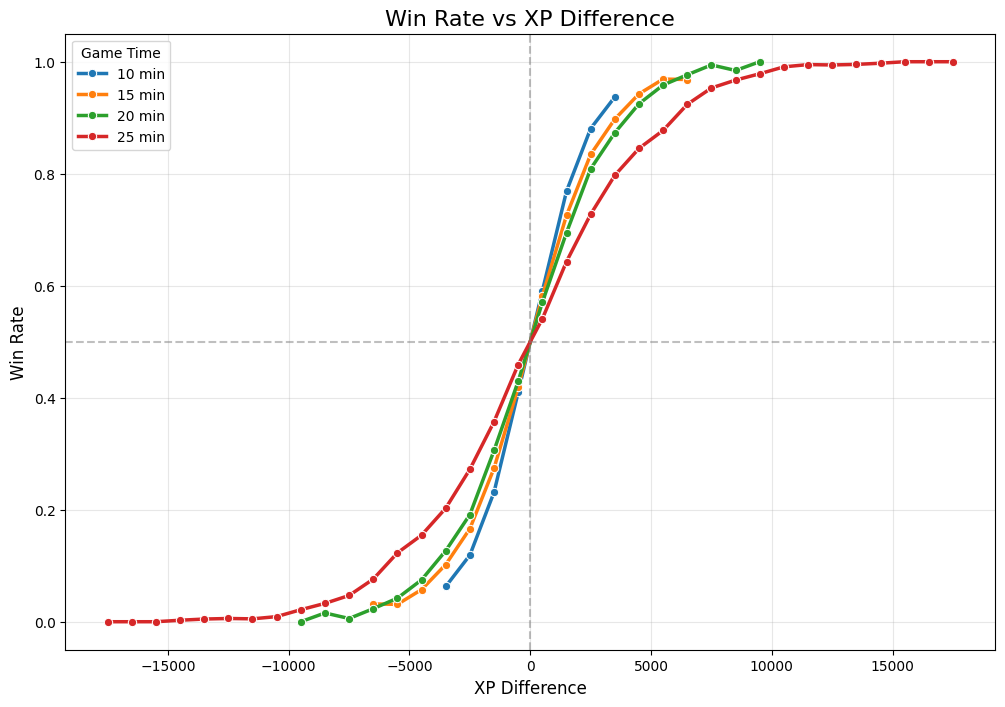

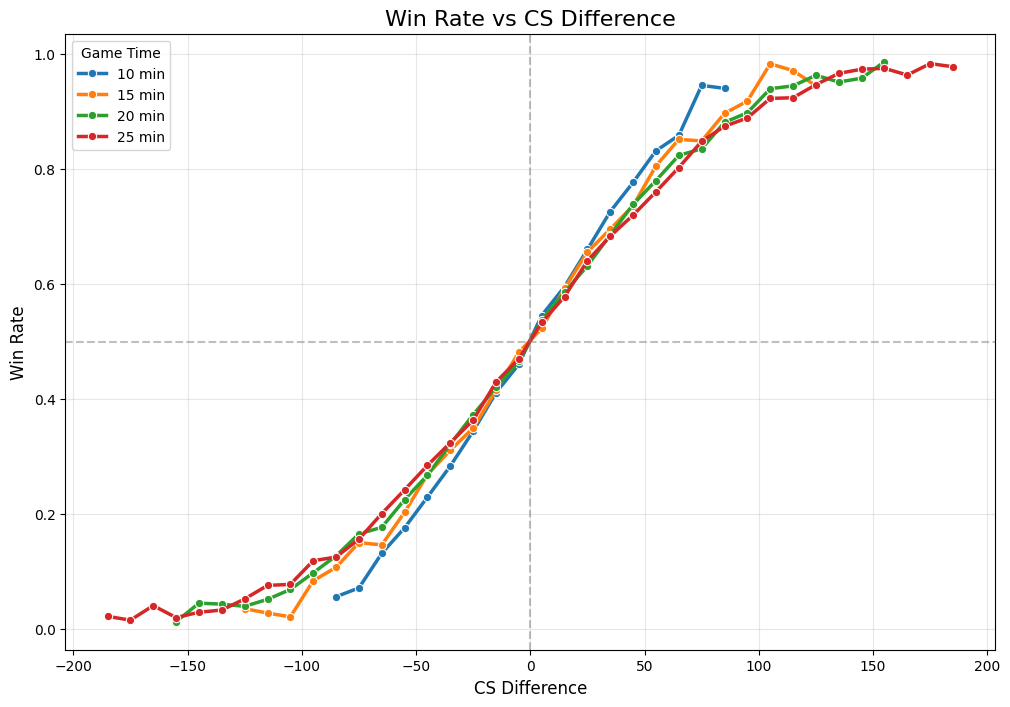

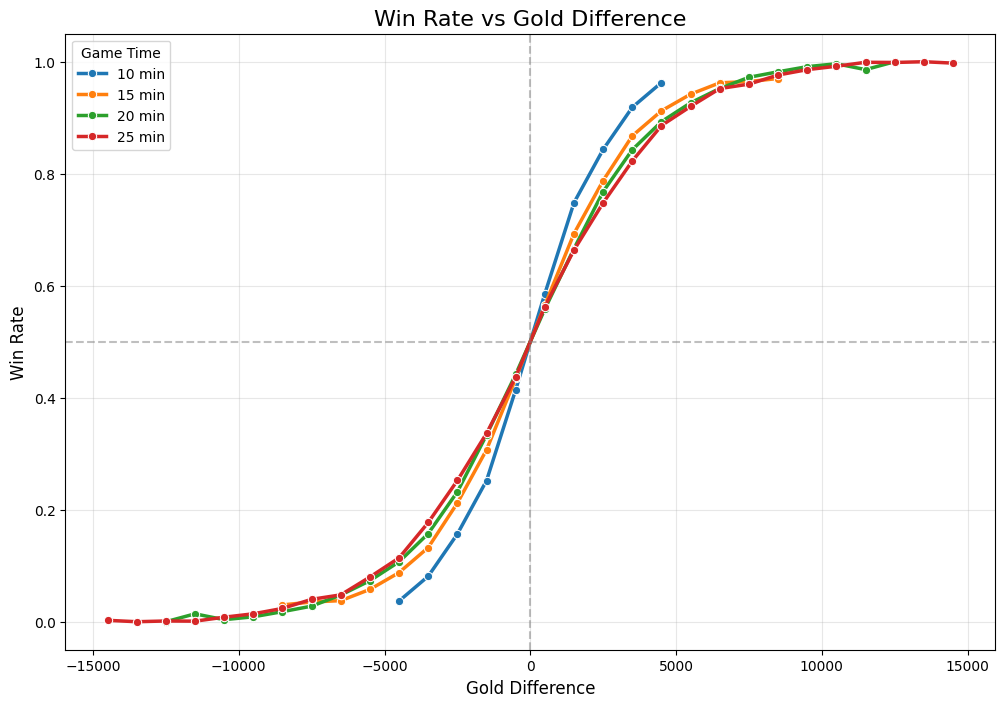

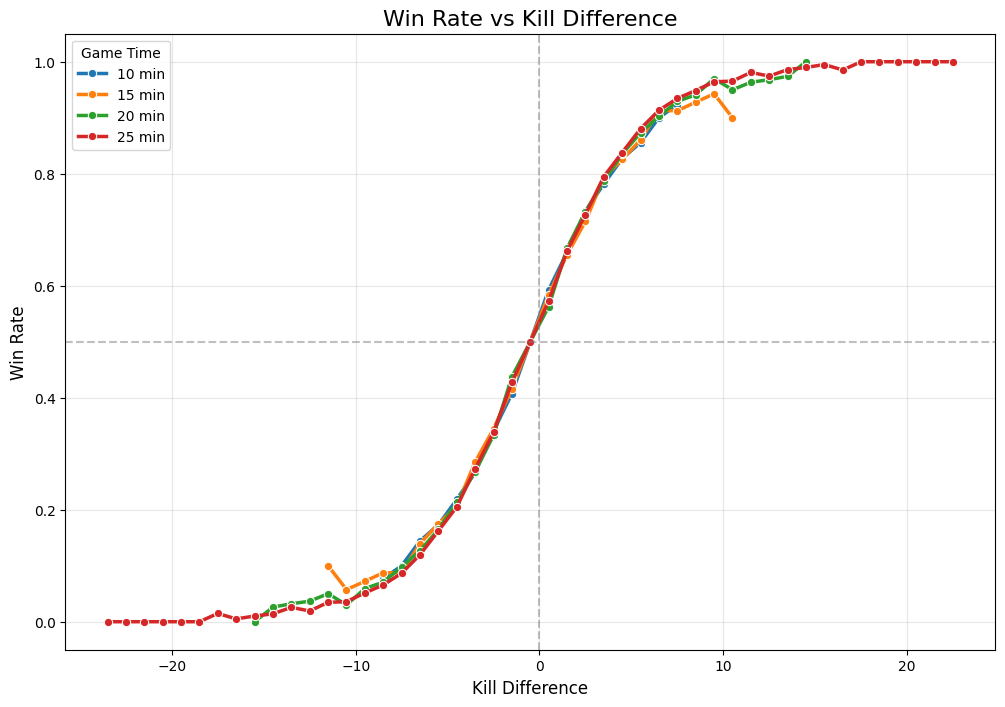

In [10]:
bins = np.arange(-15000, 15001, 1000)
labels = (bins[:-1] + bins[1:]) / 2  # Use the center of the bin for the x-axis label

# 3. Initialize the plot
plt.figure(figsize=(12, 8))
time_points = [10, 15, 20, 25]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Specific colors for each line

time_points = [10, 15, 20, 25]
for t in time_points:
    # Kills Diff = Team Kills - Opponent Kills
    realtime_df[f'killsdiffat{t}'] = realtime_df[f'killsat{t}'] - realtime_df[f'opp_killsat{t}']

# 4. Loop through each time point to process and plot data
def plot_diff_impact(df, col_prefix, bins, x_label, title, filename, min_games=50):
    time_points = [10, 15, 20, 25]
    
    # Calculate bin centers for plotting
    labels = (bins[:-1] + bins[1:]) / 2
    
    plt.figure(figsize=(12, 8))
    
    for t in time_points:
        col = f'{col_prefix}{t}'
        
        # Prepare data
        temp_df = df[[col, 'result']].copy().dropna()
        temp_df['bin'] = pd.cut(temp_df[col], bins=bins, labels=labels)
        
        # Aggregate
        agg = temp_df.groupby('bin')['result'].agg(['mean', 'count']).reset_index()
        agg['bin'] = agg['bin'].astype(float)
        
        # Filter for sufficient data
        agg = agg[agg['count'] >= min_games]
        
        # Plot
        sns.lineplot(x='bin', y='mean', data=agg, label=f'{t} min', linewidth=2.5, marker='o')

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Game Time')
    # plt.savefig(filename)
    plt.show()
    plt.close()

# Plot XP Diff
xp_bins = np.arange(-20000, 20001, 1000)
plot_diff_impact(realtime_df, 'xpdiffat', xp_bins, 'XP Difference', 'Win Rate vs XP Difference', 'xp_diff_winrate.png')

# Plot CS Diff
cs_bins = np.arange(-200, 201, 10)
plot_diff_impact(realtime_df, 'csdiffat', cs_bins, 'CS Difference', 'Win Rate vs CS Difference', 'cs_diff_winrate.png')

# Plot Gold Diff
gold_bins = np.arange(-15000, 15001, 1000)
plot_diff_impact(realtime_df, 'golddiffat', gold_bins, 'Gold Difference', 'Win Rate vs Gold Difference', 'gold_diff_winrate.png')

plot_diff_impact(realtime_df, 'killsdiffat', np.arange(-30, 31, 1), 
                 'Kill Difference', 'Win Rate vs Kill Difference', 'kill_diff_winrate.png')

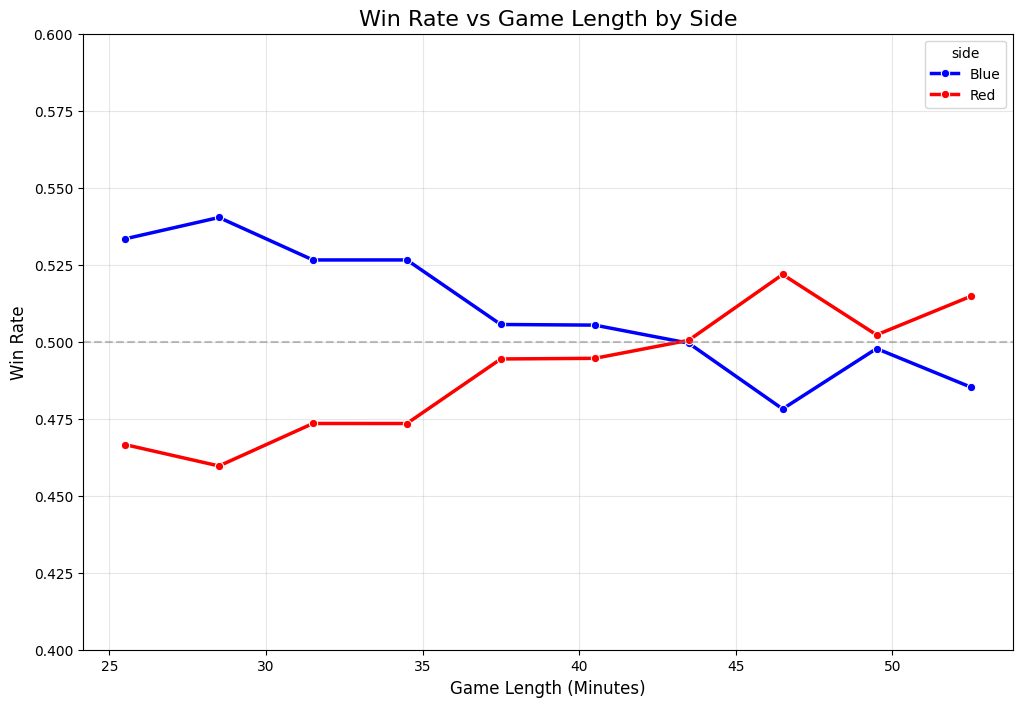

In [11]:

# Convert gamelength to minutes
realtime_df['gamelength_min'] = realtime_df['gamelength'] / 60

# Define 3-minute bins from 15 to 60 minutes
bins = np.arange(15, 61, 3)
labels = (bins[:-1] + bins[1:]) / 2

# Create bins
realtime_df['time_bin'] = pd.cut(realtime_df['gamelength_min'], bins=bins, labels=labels)

# Group by Side and Time Bin
agg = realtime_df.groupby(['side', 'time_bin'])['result'].agg(['mean', 'count']).reset_index()

# Filter out bins with insufficient data
agg = agg[agg['count'] >= 50]
agg['time_bin'] = agg['time_bin'].astype(float)

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    x='time_bin', 
    y='mean', 
    hue='side', 
    data=agg, 
    palette={'Blue': 'blue', 'Red': 'red'}, 
    marker='o', 
    linewidth=2.5
)

plt.title('Win Rate vs Game Length by Side', fontsize=16)
plt.xlabel('Game Length (Minutes)', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
# Limit Y-axis to relevant range to see the crossover clearly
plt.ylim(0.4, 0.6) 

plt.show()